In [1]:
import gc
import os
import numpy as np 
import pandas as pd 
import utils.paths as plh
import matplotlib.pyplot as plt
import utils.read_utils as hlpread
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from src.models.predict_model import employee_access_resource
from src.models.feature_eng.TE_KFold import KFoldTargetEncoder
from src.models.feature_eng.FreqEncoding import FrequencyEncoding
from src.models.feature_eng.Combine_feature import CombineFeatures
from src.models.feature_eng.KFoldFreqEncoding import KFoldFrequencyEncoding
from src.models.feature_eng.CountVectorizerEncoding import CountVectorizerEncoding
from src.models.feature_eng.TFIDFVectorizerEncoding import TFIDFVectorizerEncoding

In [2]:
PROJECT_ROOT = plh.get_project_root()

train_data = os.path.join(PROJECT_ROOT, 
                          hlpread.read_yaml_key('data_source.data_folders'),
                          hlpread.read_yaml_key('data_source.prepared.folder'),
                          hlpread.read_yaml_key('data_source.prepared.clean_train'),
                        )
train = hlpread.read_from_parquet(train_data)

print(train.shape)

print(train.columns)
#col_use = [x for x in train.columns if not x in ['ROLE_TITLE', 'MGR_ID']]
#train = train[col_use]
#targetcol = 'ACTION'

#te_col = list(train.columns)
#te_col.remove(targetcol)

(30391, 10)
Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')


# Eval performance of experiment models #

## Experiment 1: Using Decision Tree ##

### Trial 1 ###
 
**Paramteres**
- random_state: 988
- max_depth: 40
- splitter: best
- min_samples_leaf: 0.001
- max_features: 0.8  

**Feature Eng Pipeline**
- frequency_encoding: true

    *Params:*
    
        - min_group_size: 2
        - n_fold: 5
        - random_seed: 2023
        - targetcol: ACTION
        - log_transform: true
        - columns: #List of columns for feature encode
            - ROLE_DEPTNAME
            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_CODE
            - ROLE_DEPTNAME_ROLE_FAMILY_DESC
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_DEPTNAME_ROLE_CODE
    
- resource_catagory_encode: true

    *Params:*

        - column_to_consider:
            - ROLE_DEPTNAME_ROLE_FAMILY

In [4]:
model_obj = employee_access_resource(os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.model_path')),
                                     os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.feature_eng')))


<AxesSubplot:>

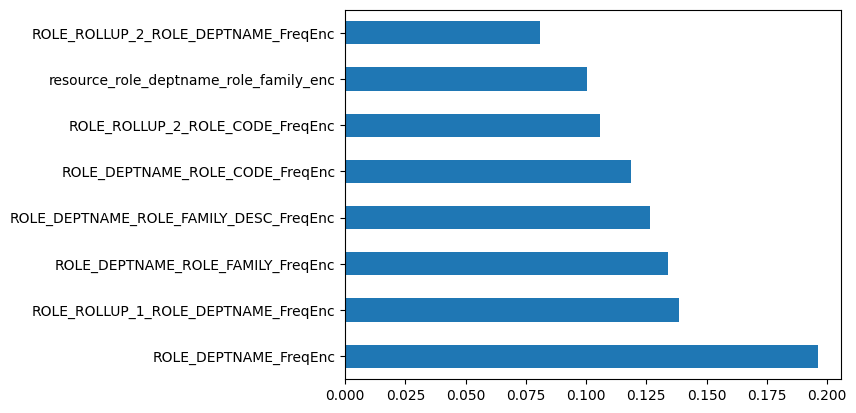

In [5]:
feat_importances = pd.Series(model_obj.model.feature_importances_, index = model_obj.model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

**Observation:**
 - ROLE_DEPTNAME_FreqEnc has is the most importance feature.

In [19]:
#train.drop(['ROLE_TITLE', 'MGR_ID'], axis = 1, inplace = True)
Y_predictions_by_class = model_obj.predict(train).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = train['ACTION'].astype(float)

In [7]:
Y_predictions_by_class

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.20930233, 0.79069767],
       ...,
       [0.04545455, 0.95454545],
       [0.06153846, 0.93846154],
       [0.03125   , 0.96875   ]])

In [10]:
auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)

Text(0.5, 0, 'ROC-AUC: 0.901')

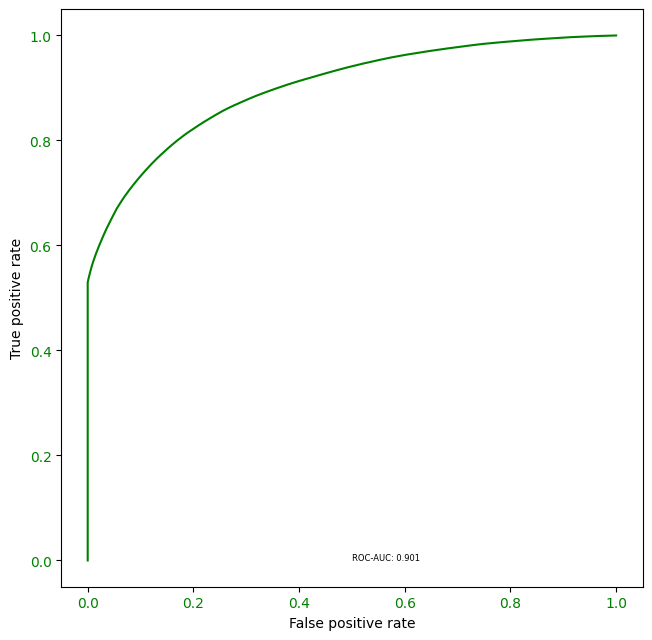

In [12]:
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)

In [ ]:
"""
pr, rc, thresholds = precision_recall_curve(Y,  Y_predictions_by_class[:,1])
pr_auc_score = average_precision_score(Y,  Y_predictions_by_class[:,1])

pr_rc_curve_df = pd.DataFrame()    
pr_rc_curve_df['precision'] = pr
pr_rc_curve_df['recall'] = rc
pr_rc_curve_df['thresholds'] = np.insert(thresholds, len(thresholds), np.nan)

fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(pr_rc_curve_df['recall'], pr_rc_curve_df['precision'], color = 'red', label = 'Precision - Recall Curve') #, marker = '-'

ax.tick_params(axis = 'both', labelcolor = 'red')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

label_str = str.format('PR-RC-AUC: {0}',  round(pr_auc_score, 3))
ax.text(0.5, 1, label_str, fontsize = 6)

plt.show()
"""

In [13]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

#Y_pred = Y_predictions_by_class.argmax(-1)  
#1.0 if Y_predictions_by_class[:,1] > 0.9 else 0.0
threshold = thresholds[ix]
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)
Y_pred

Best Threshold=0.934426, G-Mean=0.816


array([1, 1, 0, ..., 1, 1, 1])

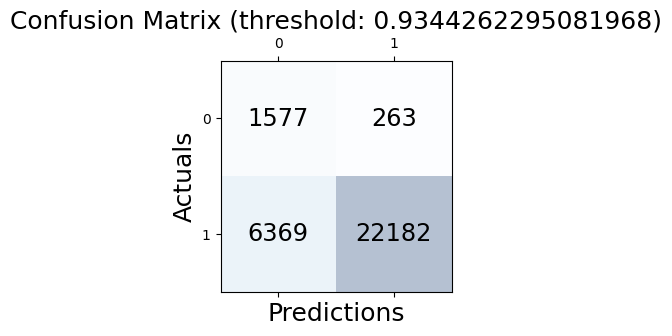

In [14]:
conf_matrix = confusion_matrix(Y, Y_pred)

#print(conf_matrix)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()

In [16]:
print(f'Balance accuracy score: {balanced_accuracy_score(Y, Y_pred)} when threshold {threshold}')

print(f"Classification report with threshold {threshold}")
print(classification_report(Y, Y_pred))

Balance accuracy score: 0.816995359562522 when threshold 0.9344262295081968
Classification report with threshold 0.9344262295081968
              precision    recall  f1-score   support

           0       0.20      0.86      0.32      1840
           1       0.99      0.78      0.87     28551

    accuracy                           0.78     30391
   macro avg       0.59      0.82      0.60     30391
weighted avg       0.94      0.78      0.84     30391



**Output:**

<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.71</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.75</td>
</tr>
</table>

This can be our baseline model

### Trial 2 ###
 
**Paramteres**
- random_state: 988
- max_depth: 40
- splitter: best
- min_samples_leaf: 0.001
- max_features: 0.8  

**Feature Eng Pipeline**
- frequency_encoding: true

    *Params:*
    
        - min_group_size: 2
        - n_fold: 5
        - random_seed: 2023
        - targetcol: ACTION
        - log_transform: true
        - columns: #List of columns for feature encode
            - ROLE_DEPTNAME
            - ROLE_ROLLUP_1_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_DEPTNAME
            - ROLE_ROLLUP_2_ROLE_CODE
            - ROLE_DEPTNAME_ROLE_FAMILY_DESC
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_DEPTNAME_ROLE_CODE
    
- resource_catagory_encode: true

    *Params:*

        - column_to_consider:
            - ROLE_DEPTNAME_ROLE_FAMILY
            - ROLE_ROLLUP_1_ROLE_FAMILY

In [3]:
model_obj = employee_access_resource(os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.model_path')),
                                     os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.feature_eng')))


<AxesSubplot:>

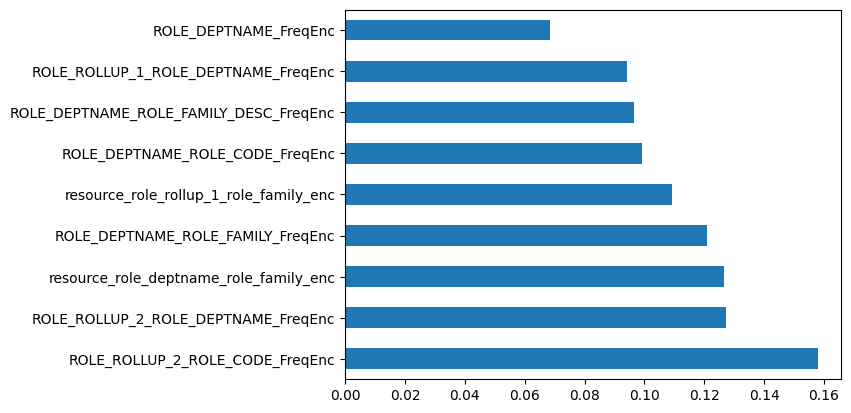

In [4]:
feat_importances = pd.Series(model_obj.model.feature_importances_, index = model_obj.model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

In [5]:
Y_predictions_by_class = model_obj.predict(train).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = train['ACTION'].astype(float)

Text(0.5, 0, 'ROC-AUC: 0.902')

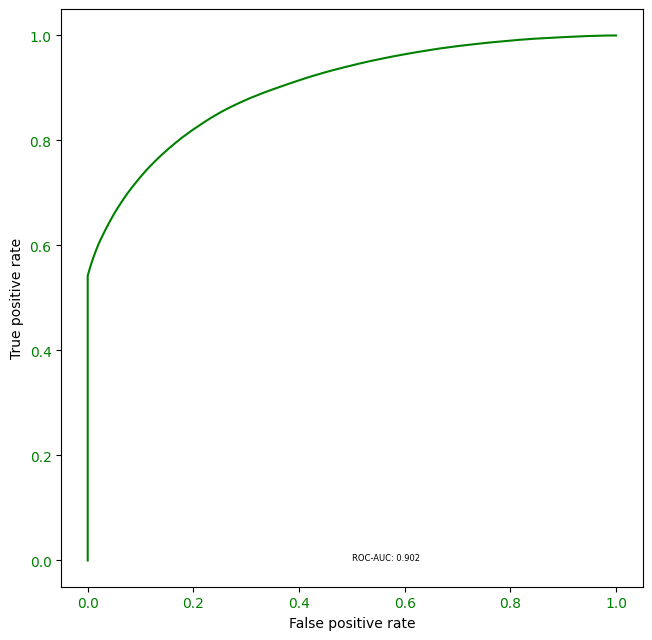

In [6]:
auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])

roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
ax.text(0.5, 0, label_str, fontsize = 6)

In [7]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

#Y_pred = Y_predictions_by_class.argmax(-1)  
#1.0 if Y_predictions_by_class[:,1] > 0.9 else 0.0
threshold = thresholds[ix]
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)

Best Threshold = 0.934783, G-Mean = 0.815


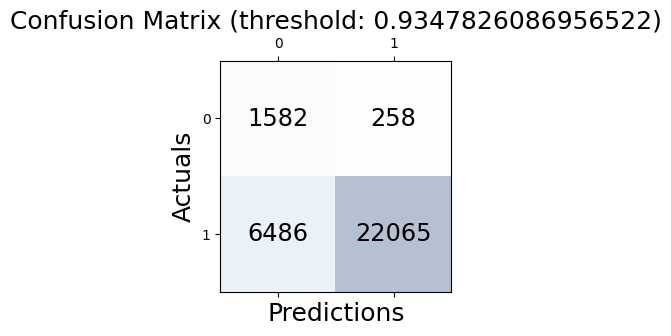

In [8]:
conf_matrix = confusion_matrix(Y, Y_pred)

#print(conf_matrix)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()

In [10]:
print(f'Balance accuracy score: {balanced_accuracy_score(Y, Y_pred)} when threshold {threshold}')

print(f"Classification report with threshold {threshold}")
print(classification_report(Y, Y_pred))

Balance accuracy score: 0.8163050902047138 when threshold 0.9347826086956522
Classification report with threshold 0.9347826086956522
              precision    recall  f1-score   support

           0       0.20      0.86      0.32      1840
           1       0.99      0.77      0.87     28551

    accuracy                           0.78     30391
   macro avg       0.59      0.82      0.59     30391
weighted avg       0.94      0.78      0.83     30391



**Output:**


<table>
<tr>
    <td></td>
    <td>Train</td>
    <td>Test</td>
</tr>
<tr>
    <td>mean cv auc score</td>
    <td>0.789</td>
    <td>-</td>
</tr>
<tr>
    <td>auc score</td>
    <td>0.90</td>
    <td>0.73</td>
</tr>
</table>

***Observation***

- We do not see much improvement in the roc in train dataset. 
- Mean roc on train is improved.
- Score on test dataset decrease.